<a href="https://colab.research.google.com/github/alanmejiaa/Datos-Masivos/blob/main/Tarea%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de Sentimiento insultos a Donald Trump en Twitter

Como figura política, Donald J. Trump utilizó Twitter para elogiar, persuadir, entretener, hacer lobby, establecer su versión de los eventos y, quizás lo más notable, amplificar su desprecio. Esta lista documenta los ataques verbales que el Sr. Trump publicó en Twitter, desde que declaró su candidatura en junio de 2015 hasta el 8 de enero, cuando Twitter lo excluyó permanentemente.


Basado en un análisis de tweets desde que el Sr. Trump declaró su candidatura a la presidencia el 16 de junio de 2015. Los retweets no están incluidos. Algunos nombres pueden estar omitidos. Esto fue publicado por primera vez en 2016; algunas de las personas insultadas han fallecido desde entonces y algunos títulos o roles públicos de las personas han cambiado.

In [1]:
import numpy as np
import pandas as pd
import string
import re
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.dates as mdates
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('insult_tweets_trump.csv')
df.head()

,Unnamed: 0,date,target,insult,tweet
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10360 entries, 0 to 10359
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10360 non-null  int64 
 1   date        10360 non-null  object
 2   target      10358 non-null  object
 3   insult      10360 non-null  object
 4   tweet       10360 non-null  object
dtypes: int64(1), object(4)
memory usage: 404.8+ KB


In [5]:
tweets = df[['date', 'insult','tweet']]
tweets.columns = ['fecha', 'insulto','tweet']
tweets['fecha'] = pd.to_datetime(tweets['fecha'], infer_datetime_format=True)
tweets['fecha'] = tweets['fecha'].dt.strftime('%Y-%m-%d')
tweets.head(3)

,fecha,insulto,tweet
0,2014-10-09,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2014-10-09,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,2015-06-16,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...


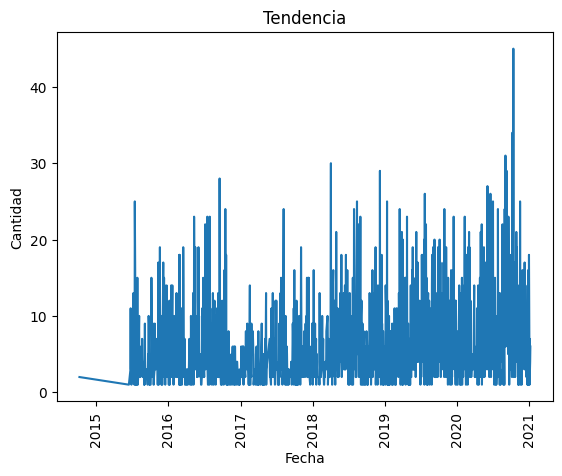

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

conteo_tweets = Counter(tweets.fecha)
fechas_unicas = sorted(conteo_tweets.keys())
cantidad_tweets = [conteo_tweets[fecha] for fecha in fechas_unicas]
fechas_unicas = [datetime.strptime(fecha, "%Y-%m-%d") for fecha in fechas_unicas]

plt.plot(fechas_unicas, cantidad_tweets)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Mostrar solo el año
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Tendencia')
plt.xticks(rotation=90)
plt.show()

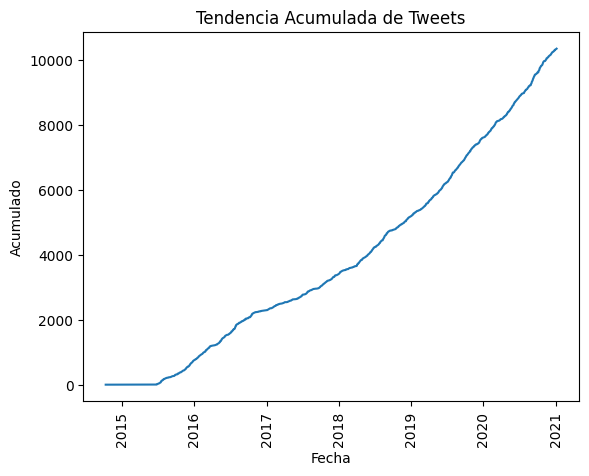

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

conteo_tweets = Counter(tweets.fecha)
fechas_unicas = sorted(conteo_tweets.keys())
cantidad_tweets = [conteo_tweets[fecha] for fecha in fechas_unicas]
fechas_unicas = [datetime.strptime(fecha, "%Y-%m-%d") for fecha in fechas_unicas]

acumulado_tweets = [sum(cantidad_tweets[:i+1]) for i in range(len(cantidad_tweets))]

plt.plot(fechas_unicas, acumulado_tweets)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel('Fecha')
plt.ylabel('Acumulado')
plt.title('Tendencia Acumulada de Tweets')
plt.xticks(rotation=90)
plt.show()

In [13]:
def limpiar_tokenizar(texto):
    newtex = texto.lower()
    newtex = re.sub('http\S+', ' ', newtex)
    regex = '[\!\"\#\$\%\&\\\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^_\`\{\|\}\~]'
    newtex = re.sub(regex , ' ', newtex)
    newtex = re.sub("\d+", ' ', newtex)
    newtex = re.sub("\s+", ' ', newtex)
    newtex = newtex.split(sep = ' ')
    newtex = [token for token in newtex if len(token) > 1]
    return(newtex)

In [14]:
tweets['twtoken'] = tweets['tweet'].apply(lambda x: limpiar_tokenizar(x))
tweets[['tweet', 'twtoken']].head()

,tweet,twtoken
0,"Can you believe this fool, Dr. Thomas Frieden ...","[can, you, believe, this, fool,, dr., thomas, ..."
1,"Can you believe this fool, Dr. Thomas Frieden ...","[can, you, believe, this, fool,, dr., thomas, ..."
2,Big time in U.S. today - MAKE AMERICA GREAT AG...,"[big, time, in, u.s., today, make, america, gr..."
3,Politician @SenatorCardin didn't like that I s...,"[politician, @senatorcardin, didn't, like, tha..."
4,"For the nonbeliever, here is a photo of @Neily...","[for, the, nonbeliever,, here, is, photo, of, ..."


In [15]:
tweets_tidy = tweets.explode(column='twtoken')
tweets_tidy = tweets_tidy.drop(columns='twtoken')
tweets_tidy = tweets_tidy.rename(columns={'twtoken':'token'})
tweets_tidy.head(3)

,fecha,insulto,tweet
0,2014-10-09,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
0,2014-10-09,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
0,2014-10-09,fool,"Can you believe this fool, Dr. Thomas Frieden ..."


In [16]:
print(tweets_tidy.columns)

Index(['fecha', 'insulto', 'tweet'], dtype='object')


In [17]:
temp_df = pd.DataFrame(tweets_tidy.groupby("insulto")["tweet"].count())
mean_length = temp_df["tweet"].mean()
std_length = temp_df["tweet"].std()
print("Longitud media:", mean_length)
print("Desviación:", std_length)

Longitud media: 51.221429632932086
Desviación: 229.81331540848083


In [18]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
tweets_tidy = tweets_tidy[~(tweets_tidy["tweet"].isin(stop_words))]

In [20]:
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [29]:
import pandas as pd

lexicon = pd.read_table(
    'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
    names=['termino', 'sentimiento']
)

lexicon_sorted = lexicon.sort_values(by='sentimiento', ascending=False)
print(lexicon_sorted.head())

           termino  sentimiento
2252   outstanding            5
392   breathtaking            5
3028      thrilled            5
2957        superb            5
1630        hurrah            5


In [30]:
twsent = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "insulto",
                            right_on = "termino",
                            how      = "inner"
                      )

twsent = twsent.drop(columns = "termino")
twsent = twsent[["fecha", "insulto", "sentimiento"]] \
                      .groupby(["fecha", "insulto"])\
                      .sum().reset_index()
twsent.head()

,fecha,insulto,sentimiento
0,2014-10-09,fool,-52
1,2015-07-01,racists,-48
2,2015-07-09,failing,-68
3,2015-07-12,pathetic,-30
4,2015-07-20,incompetent,-42


In [27]:
print(f"Positivos: {round(100 * np.mean(twsent.sentimiento > 0), 2)}")
print(f"Neutros  : {round(100 * np.mean(twsent.sentimiento == 0), 2)}")
print(f"Negativos: {round(100 * np.mean(twsent.sentimiento < 0), 2)}")

Positivos: 0.0
Neutros  : 0.0
Negativos: 100.0


Como su nombre lo indica los tweets con insultos sobre Trump, son todos negativos, esto pudimos comprobarlo haciendo el analisis de sentimiento y observamos que es verdad. En este caso el analisis de sentimiento nos dio la razon sobre la naturaleza de la base